In [60]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from google.colab import files
uploaded = files.upload()

Saving 202501.xlsx to 202501 (4).xlsx


In [61]:
# 데이터 불러오기
df = pd.read_excel('202501.xlsx')

In [62]:
# 시간 데이터로 변환 (Pump-Begin 기준)
df['Pump-Begin'] = pd.to_datetime(df['Pump-Begin'])

In [63]:
# 금속 컬럼 추출 (Al ~ Bi)
metal_columns = df.columns[df.columns.str.endswith('(ng/m3)')]

In [88]:
# 음수값 전처리
df[metal_columns] = df[metal_columns].applymap(lambda x: x if x >= 0 else None)

/tmp/ipython-input-4223683984.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[metal_columns] = df[metal_columns].applymap(lambda x: x if x >= 0 else None)


In [84]:
# 날짜 컬럼 생성 (datetime을 date로 변환)
df['Date'] = df['Pump-Begin'].dt.date

# 날짜 분할 (5일 단위)
unique_dates = sorted(df['Date'].unique())
chunks = [unique_dates[i:i+5] for i in range(0, len(unique_dates), 5)]

In [85]:
# 금속 총합 계산
df['Metal_Total'] = df[metal_columns].sum(axis=1)

In [93]:
# 금속을 총합 기준으로 정렬
metal_sums = df[metal_columns].sum().sort_values(ascending=False)  # 총합 기준 내림차순
metal_columns_sorted = metal_sums.index.tolist()  # 정렬된 금속 컬럼 리스트

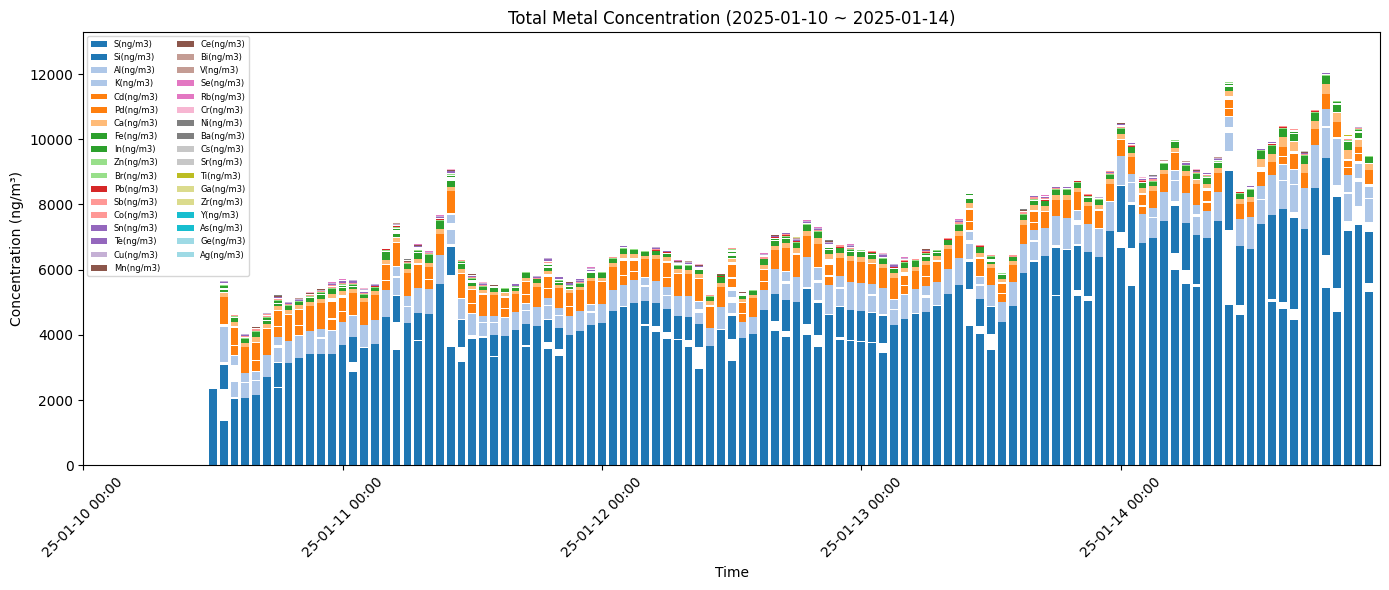

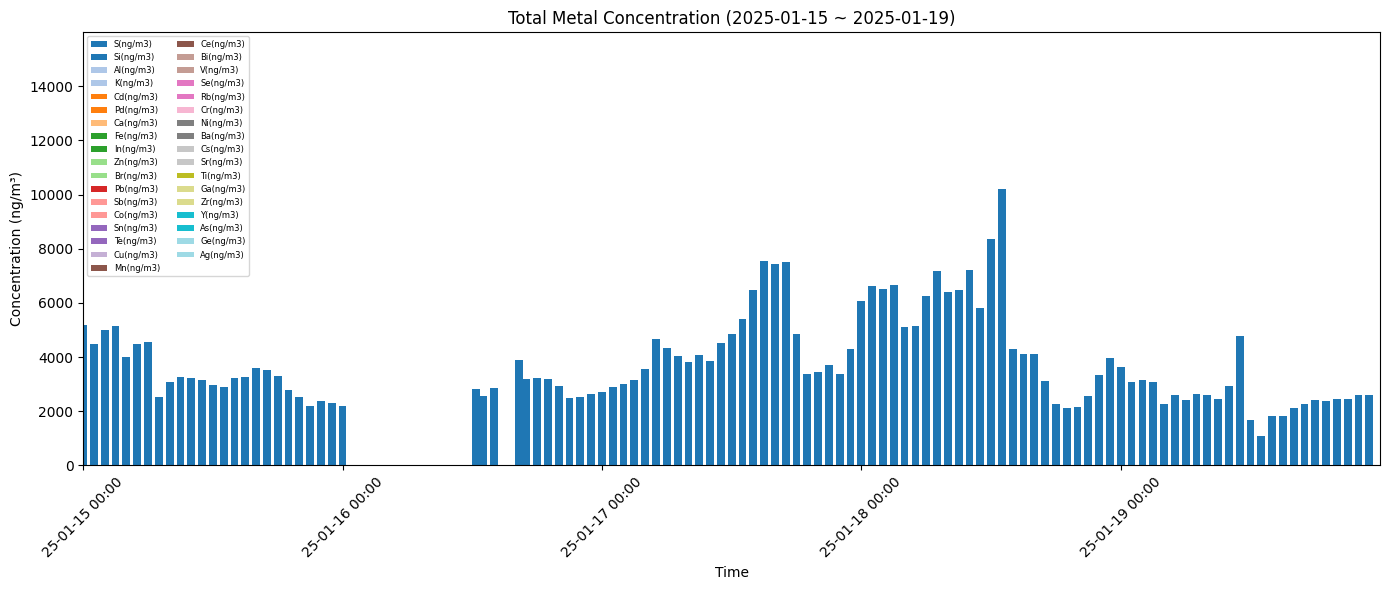

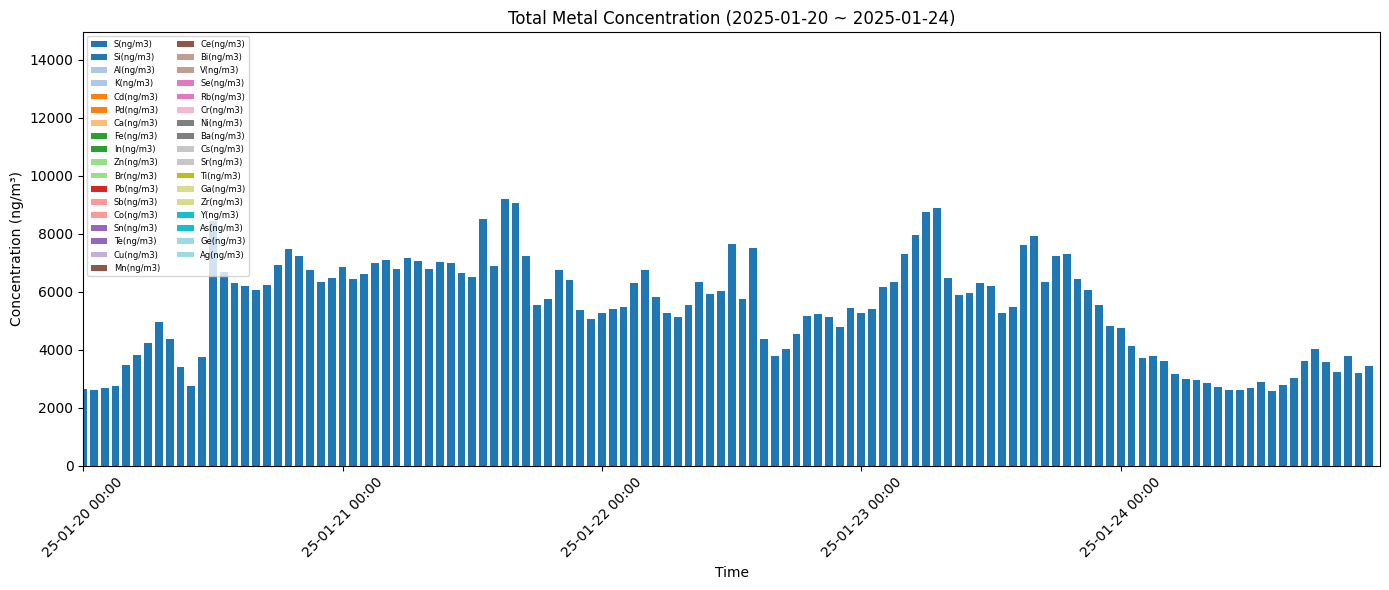

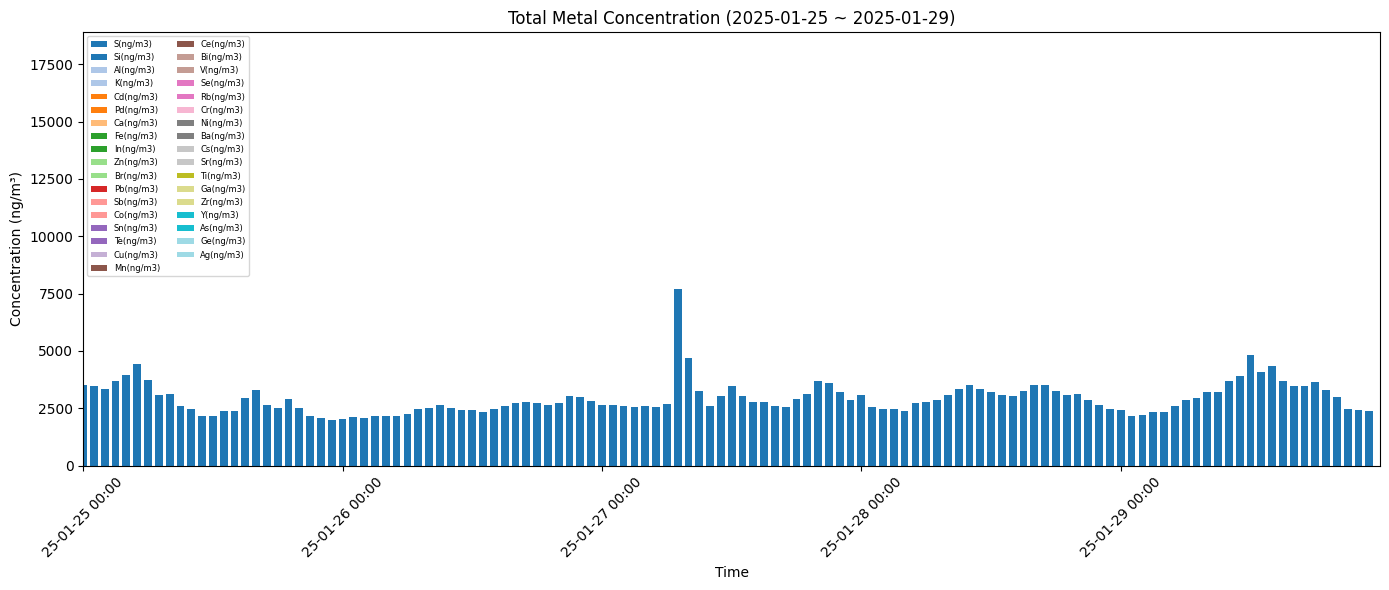

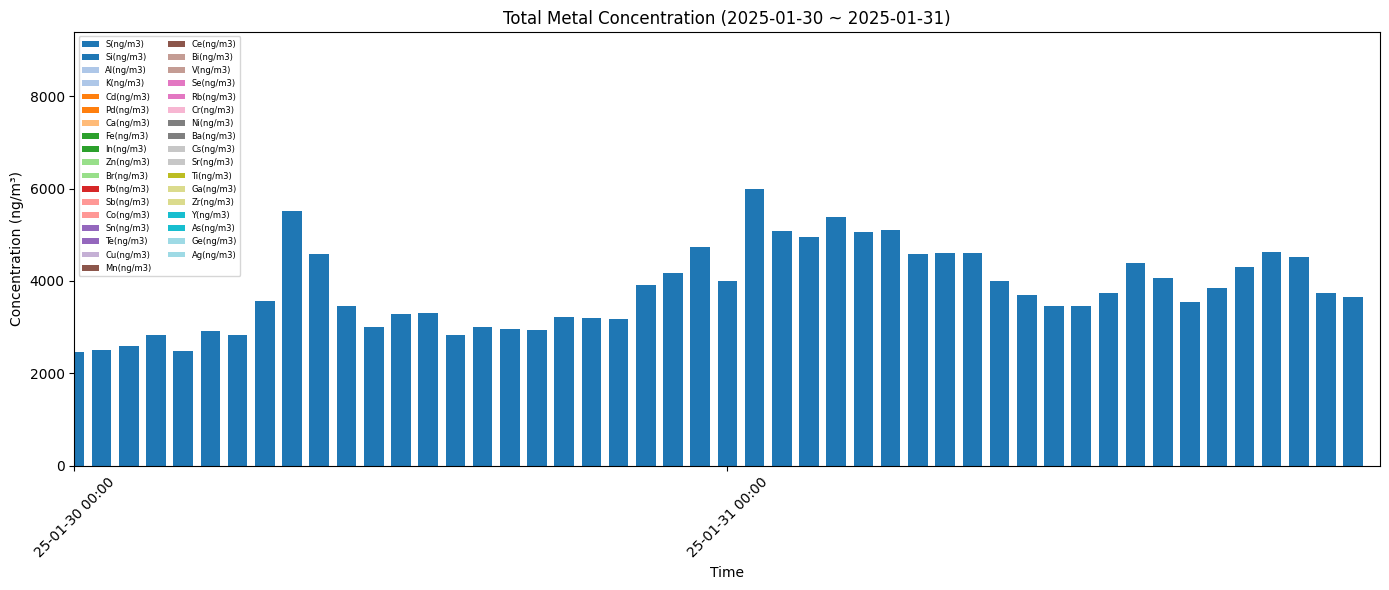

In [96]:
# 금속 총합 누적 막대그래프 생성
for date_group in chunks:
    start_date = pd.to_datetime(min(date_group))
    end_date = pd.to_datetime(max(date_group)) + pd.Timedelta(hours=23, minutes=59)

    temp_df = df[df['Date'].isin(date_group)]
    temp_df = temp_df[(temp_df['Pump-Begin'] >= start_date) & (temp_df['Pump-Begin'] <= end_date)]
    temp_df = temp_df.sort_values('Pump-Begin')

    # Y축 최대값 설정
    chunk_ymax = temp_df[metal_columns_sorted].sum(axis=1).max() * 1.1

    plt.figure(figsize=(14, 6))
    bottom_values = pd.Series([0]*len(temp_df))

    # 금속 순서 고정, 값 없으면 0으로만 표시
    for idx, metal_col in enumerate(metal_columns_sorted):
        plt.bar(temp_df['Pump-Begin'], temp_df[metal_col],
                bottom=bottom_values, width=0.03,
                label=metal_col, color=colors(idx))
        bottom_values += temp_df[metal_col]

    # 그래프 기본 설정
    plt.title(f'Total Metal Concentration ({start_date.date()} ~ {end_date.date()})')
    plt.xlabel('Time')
    plt.ylabel('Concentration (ng/m³)')

    # X축 설정 : 가독성 위해 하루 단위로 표시, 데이터는 1시간 단위
    plt.xlim(start_date, end_date)
    plt.ylim(0, chunk_ymax)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
    plt.xticks(rotation=45)

    plt.legend(loc='upper left', fontsize=6, ncol=2)

    # 그래프 출력
    plt.tight_layout()
    plt.show()